**Fourier Transform in Numpy**:
First we shall see how to find Fourier Transform using Numpy. Numpy has an FFT package to do this. np.fft.fft2() provides us the frequency transform which will be a complex array. Its first argument is the input image, which is grayscale. Second argument is optional which decides the size of output array. If it is greater than size of input image, input image is padded with zeros before calculation of FFT. If it is less than input image, input image will be cropped. If no arguments passed, Output array size will be same as input.

Now once we got the result, zero frequency component (DC component) will be at top left corner. If we want to bring it to center, we need to shift the result by N/2 in both the directions. This is simply done by the function, np.fft.fftshift(). (It is more easier to analyze). Once we found the frequency transform, you can find the magnitude spectrum.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving sample.jpg to sample.jpg


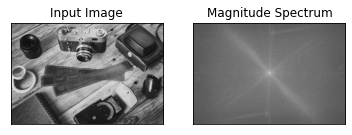

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('sample.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

We can see more whiter region at the center showing low frequency content is more.

So we found the frequency transform. Now we can do some operations in frequency domain, like high pass filtering and reconstruct the image, i.e, find inverse DFT. For that you simply remove the low frequencies by masking with a rectangular window of size 60x60. Then apply the inverse shift using np.fft.ifftshift() so that DC component again come at the top-left corner. Then find inverse FFT using np.ifft2() function. The result, again, will be a complex number. You can take its absolute value.

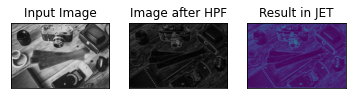

In [4]:
rows, cols = img.shape
crow,ccol = rows/2 , cols/2
fshift[int(crow)-30:int(crow)+30, int(ccol)-30:int(ccol)+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()

The result shows High Pass Filtering is an edge detection operation. This also shows that most of the image data is present in the Low frequency region of the spectrum. Anyway we have seen how to find DFT, IDFT etc in Numpy. 

If we closely watch the result, especially the last image in JET color, we can see some artifacts. It shows some ripple like structures there, and it is called ringing effects. It is caused by the rectangular window we used for masking. This mask is converted to sinc shape which causes this problem. So rectangular windows is not used for filtering. Better option is Gaussian Windows.

**Fourier Transform in OpenCV**:
OpenCV provides the functions cv2.dft() and cv2.idft() for this. It returns the same result as previous, but with two channels. First channel will have the real part of the result and second channel will have the imaginary part of the result. The input image should be converted to np.float32 first. We will see how to do it.

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [6]:
from google.colab import files
uploaded = files.upload()

Saving sample.jpg to sample (1).jpg


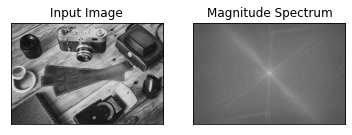

In [8]:
img = cv2.imread('sample.jpg',0)

dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

So, now we have to do inverse DFT. In previous session, we created a HPF, this time we will see how to remove high frequency contents in the image, ie we apply LPF to image. It actually blurs the image. For this, we create a mask first with high value (1) at low frequencies, ie we pass the LF content, and 0 at HF region.

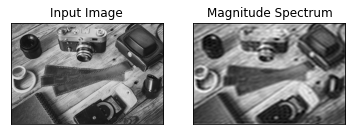

In [11]:
rows, cols = img.shape
crow,ccol = rows/2 , cols/2

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[int(crow)-30:int(crow)+30, int(ccol)-30:int(ccol)+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

As usual, OpenCV functions cv2.dft() and cv2.idft() are faster than Numpy counterparts. But Numpy functions are more user-friendly. 

**Performance Optimization of DFT:**
Performance of DFT calculation is better for some array size. It is fastest when array size is power of two. The arrays whose size is a product of 2’s, 3’s, and 5’s are also processed quite efficiently. So if you are worried about the performance of your code, you can modify the size of the array to any optimal size (by padding zeros) before finding DFT. For OpenCV, you have to manually pad zeros. But for Numpy, you specify the new size of FFT calculation, and it will automatically pad zeros for you.

So how do we find this optimal size ? OpenCV provides a function, cv2.getOptimalDFTSize() for this. It is applicable to both cv2.dft() and np.fft.fft2(). Let’s check their performance using IPython magic command %timeit.

In [14]:
from google.colab import files
uploaded = files.upload()

Saving sample.jpg to sample (2).jpg


In [16]:
from google.colab.patches import cv2_imshow
img = cv2.imread('sample.jpg',0)
rows,cols = img.shape
print(rows,cols)

867 1300


In [17]:
nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print(nrows, ncols)

900 1350


See, the size (867,1300) is modified to (900, 1350). Now let’s pad it with zeros (for OpenCV) and find their DFT calculation performance. You can do it by creating a new big zero array and copy the data to it, or use cv2.copyMakeBorder().

In [18]:
nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = img

In [22]:
right = ncols - cols
bottom = nrows - rows
bordertype = cv2.BORDER_CONSTANT #just to avoid line breakup in PDF file
nimg = cv2.copyMakeBorder(img,0,bottom,0,right,bordertype, value = 0)

In [24]:
%timeit fft1 = np.fft.fft2(img)

39.3 ms ± 748 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit fft2 = np.fft.fft2(img,[nrows,ncols])

41.3 ms ± 869 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit dft1= cv2.dft(np.float32(img),flags=cv2.DFT_COMPLEX_OUTPUT)

14.9 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)

9.67 ms ± 64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can see that OpenCV functions are quite faster than Numpy functions for non-padding and padding cases comparisons respectively.